# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom_old.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [4]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0
dataDF['excludedRelic'] = dataDF['Omega'] > 0.13
#Xenon 1T curve (from micromegas):
data_1t_lnM = [1.790E+00, 1.885E+00, 2.006E+00, 2.148E+00, 2.297E+00, 2.449E+00, 2.598E+00, 2.783E+00, 2.961E+00, 3.117E+00, 3.302E+00, 3.444E+00, 3.614E+00, 3.796E+00, 4.037E+00, 4.268E+00, 4.581E+00, 4.904E+00, 5.178E+00, 5.441E+00, 5.768E+00, 6.095E+00, 6.369E+00, 6.550E+00, 6.891E+00]
data_1t_lnS = [1.040E+00, 2.794E-02,-1.003E+00,-2.035E+00,-2.888E+00,-3.591E+00,-4.144E+00,-4.717E+00,-5.111E+00,-5.326E+00,-5.458E+00,-5.486E+00,-5.440E+00,-5.375E+00,-5.178E+00,-4.982E+00,-4.711E+00,-4.412E+00,-4.150E+00,-3.925E+00,-3.598E+00,-3.270E+00,-3.009E+00,-2.812E+00,-2.485E+00]
xenonF = interp1d(data_1t_lnM,data_1t_lnS,
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
@np.vectorize
def xenonUL(mDM):
    return 1e-8*np.exp(xenonF(np.log(mDM))) #90% upper limit on sigmaNucleon (pb)

rDD = (dataDF['Omega']/0.12)*(dataDF['proton_SI']+dataDF['neutron_SI'])/2.0
rDD = rDD/xenonUL(dataDF['mass.1000022'])
dataDF['excludedDD'] = (rDD > 1)

#### Add c*tau column for charginos

In [5]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]
excludedDM = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == True)]
excludedDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                    & (dataDF['excludedDD'] == True)]

allowed = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                 & (dataDF['excludedDD'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total excluded (relic) = %i'%(len(excludedDM)))
print('Total excluded (DD) = %i'%(len(excludedDD)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 96629
Total excluded (LHC) = 7269
Total excluded (relic) = 42067
Total excluded (DD) = 11756
Total allowed = 35537



### Create analysis label for excluded points

In [8]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels


In [9]:
print(excluded['label'].unique())

['CMS-EXO-19-010 (TDTM1F,TDTM2F)' 'ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'
 'ATLAS-SUSY-2018-06 (TChiWZ)' 'CMS-SUS-17-004 (TChiWZoff)'
 'CMS-SUS-17-004 (TChiWZ)' 'ATLAS-SUSY-2016-24 (TChiWZ)'
 'ATLAS-SUSY-2019-08 (TChiWH)' 'ATLAS-SUSY-2018-32 (TChiWW)'
 'CMS-SUS-13-006 (TChiWZoff)' 'ATLAS-SUSY-2013-12 (TChiWZ)'
 'CMS-SUS-16-039 (TChiWZoff)']


In [10]:
for label in sorted(excluded['label'].unique()):
    print(label,len(excluded[excluded['label'] == label]))

ATLAS-SUSY-2013-12 (TChiWZ) 1
ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F) 6590
ATLAS-SUSY-2016-24 (TChiWZ) 7
ATLAS-SUSY-2018-06 (TChiWZ) 41
ATLAS-SUSY-2018-32 (TChiWW) 49
ATLAS-SUSY-2019-08 (TChiWH) 466
CMS-EXO-19-010 (TDTM1F,TDTM2F) 18
CMS-SUS-13-006 (TChiWZoff) 3
CMS-SUS-16-039 (TChiWZoff) 1
CMS-SUS-17-004 (TChiWZ) 38
CMS-SUS-17-004 (TChiWZoff) 55


In [12]:
excluded[excluded['label'] == 'CMS-SUS-17-004 (TChiWZoff)']['filename']

47593    ew_yzgxw9fp.slha
79225    ew_56prihhg.slha
66963    ew_wsfwao0b.slha
29012    ew_5yd8_ib0.slha
47963    ew_3ec_3cfy.slha
6347     ew_thf3_ogd.slha
11601    ew_wb52i4kb.slha
34203    ew_rwbn9a4k.slha
2351     ew_lzc_x6jn.slha
83248    ew_54jviv07.slha
6916     ew_rqr8ospi.slha
41249    ew_uz4pbhzz.slha
81351    ew_vztzezlu.slha
10542    ew_nxt1673f.slha
81718    ew_vp6q2eds.slha
31365    ew_fa1zj_jf.slha
69445    ew_94nq33ne.slha
57152    ew_urwdab3e.slha
47353    ew_7b57k21l.slha
83202    ew_8csoqrqb.slha
87503    ew_iupv10_t.slha
38583    ew_k0m2vgj4.slha
49776    ew_5cpml74d.slha
71987    ew__h_e2zjp.slha
32472    ew_kz_sd64y.slha
5337     ew_4oagtlef.slha
5730     ew_sxw88n7f.slha
43050    ew_a5icy0mz.slha
8779     ew_c8t7sc46.slha
29511    ew_3fugokw0.slha
82768    ew_u23hw2lg.slha
95883    ew_a8bdcw3v.slha
53993    ew_wfohu_dh.slha
58282    ew_ixzk00ml.slha
53298    ew_j5xrhv_a.slha
56698    ew_e2l6zgd_.slha
31643    ew_vhawsha2.slha
3316     ew_y5hy3fks.slha
83898    ew_

### Get relevant official exclusion curves

In [9]:
excCurves = {}
excATLAS = np.genfromtxt('../EWino/data/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'] = np.array(list(zip(excATLAS['mC1_GeV'],1.967e-16/excATLAS['width_GeV'])))


excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
excCurves['ATLAS-SUSY-2016-24 (TChiWZ)'] = np.genfromtxt('../EWino/data/HEPData-ins1658902-v1-Table_20.csv',
                       delimiter=',', skip_header=9)
excCurves['ATLAS-SUSY-2019-08 (TChiWH)'] = np.genfromtxt('../EWino/data/HEPData-ins1755298-v1-Observed_limit_1lbb.csv',
                       delimiter=',', skip_header=11)
excCurves['ATLAS-SUSY-2018-32 (TChiWW)'] = np.genfromtxt('../EWino/data/HEPData-ins1750597-v1-Exclusion_contour_(obs)_1.csv',
                       delimiter=',', skip_header=10)
excCurves['CMS-SUS-13-006 (TChiWZoff)'] = np.genfromtxt('../EWino/data/CMS_SUS_13_006_TChiWZ_obs.csv', 
                                                      delimiter=',')

excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'] = np.genfromtxt('../EWino/data/CMS_SUS_19_010_TChiWZ_obs.csv', 
                                                      delimiter=',')
#Fix column order:
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[0,1]] = excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[1,0]]
#Convert width to lifetime
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]= 1.967e-16/excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]

#### Plot distribution excluded points

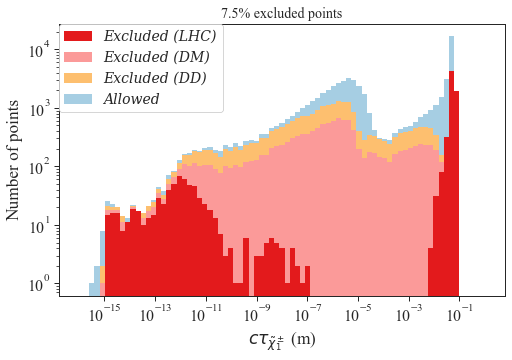

In [10]:
plt.figure(figsize=(8,5))
xExcluded = excluded['ctau.1000024']
xExcludedDM = excludedDM['ctau.1000024']
xExcludedDD = excludedDD['ctau.1000024']
xAllowed = allowed['ctau.1000024']
nbins = np.logspace(-16,0,80)
colors = np.take(sns.color_palette("Paired"),[5,4,6,0],axis=0)
plt.hist([xExcluded,xExcludedDD,xExcludedDD,xAllowed],nbins,stacked=True, 
                            histtype='barstacked', label=['Excluded (LHC)','Excluded (DM)',
                                                          'Excluded (DD)','Allowed'],
                            linewidth=0, fill=True, color=colors)
lgd = plt.legend(loc='upper left', borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size' : 14},framealpha=1.)
plt.yscale('log')
plt.xscale('log')
plt.title('%1.1f%% excluded points' %(100*len(excluded)/float(len(dataDF))), fontsize=14)
plt.xlabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)')
plt.ylabel('Number of points')
plt.show()

### Plot excluded points grouped by most excluding analysis

ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)    6586
ATLAS-SUSY-2019-08 (TChiWH)            442
ATLAS-SUSY-2018-32 (TChiWW)             54
ATLAS-SUSY-2018-06 (TChiWZ)             38
CMS-PAS-SUS-17-004 (TChiWZ)             31
CMS-PAS-SUS-17-004 (TChiWZoff)          29
CMS-SUS-17-004 (TChiWZoff)              27
CMS-EXO-19-010 (TDTM1F,TDTM2F)          18
CMS-SUS-17-004 (TChiWZ)                  9
ATLAS-SUSY-2016-24 (TChiWZ)              6
CMS-SUS-13-006 (TChiWZoff)               3
CMS-PAS-SUS-12-022 (TChiWZ)              2
ATLAS-SUSY-2013-12 (TChiWZ)              1
ATLAS-SUSY-2017-03 (TChiWZ)              1
CMS-SUS-16-039 (TChiWZoff)               1
ATLAS-CONF-2013-035 (TChiWZoff)          1
Name: label, dtype: int64


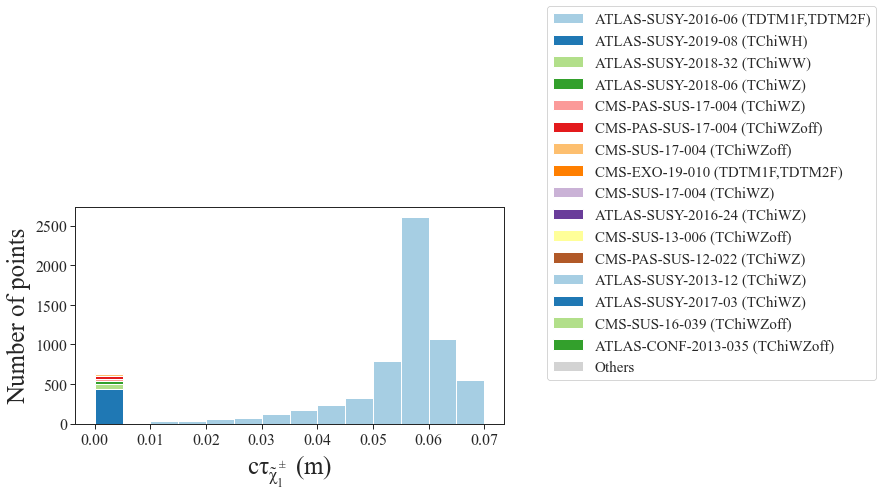

In [11]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
print(anas)

plt.figure(figsize=(13,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
first = True
labels= []
hists = []
colors = []
xothers = []
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['ctau.1000024']
    if anas[ana] < 0:
        xothers += x.tolist()        
        continue
    else:
        color = colorDict[ana]
        label = ana
    
    hists.append(x)
    colors.append(color)
    labels.append(label)

hists.append(xothers)
labels.append('Others')
colors.append(c_other)
plt.hist(hists,nbins,color=colors,label=labels,
                            histtype='barstacked',
                            linewidth=1, fill=True)

lgd = plt.legend(loc=(1.1,0.2), borderaxespad=0.,framealpha=1.,fontsize=15)

# plt.ylim(0,6500)
# plt.xlim(0,0.07)
# plt.title('SModelS v2.0', fontsize=26)
plt.xlabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.ylabel('Number of points',fontsize = 25)
plt.tight_layout()
plt.savefig('Wino_v2.png')
plt.show()

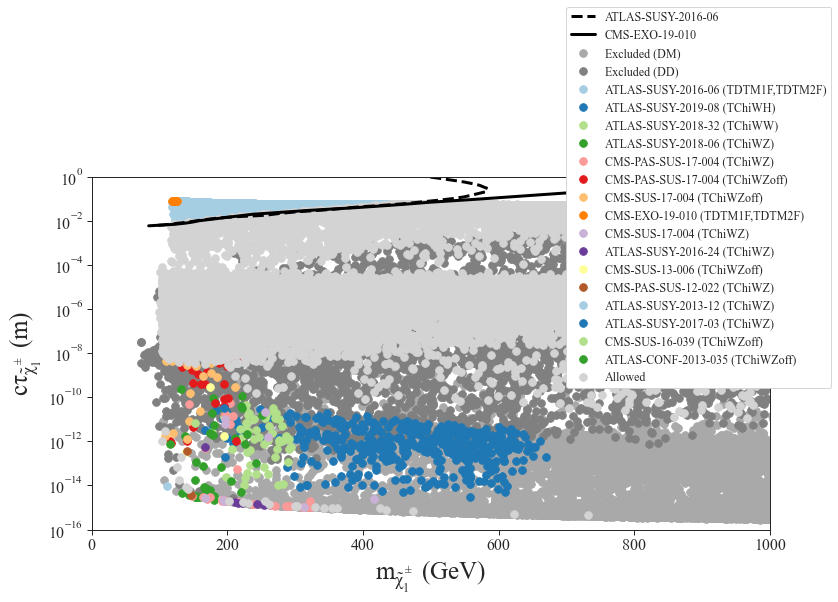

In [12]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(12,8))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'



x = excludedDM['mass.1000024']
y = excludedDM['ctau.1000024']
plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


x = excludedDD['mass.1000024']
y = excludedDD['ctau.1000024']
plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)


for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['ctau.1000024']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

x = allowed['mass.1000024']
y = allowed['ctau.1000024']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
    
    
    
#Add official DT exclusion curve
offExc = excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)']
c = colorDict['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)']
plt.plot(offExc[:,0],offExc[:,1],label='ATLAS-SUSY-2016-06',linewidth=3,linestyle='--',color='black')
offExc = excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)']
plt.plot(offExc[:,0],offExc[:,1],label='CMS-EXO-19-010',linewidth=3,linestyle='-',color='black')

lgd = plt.legend(loc=(0.7,0.4), framealpha=1.,fontsize=12)
plt.yscale('log')
plt.ylim(1e-16,1)
# plt.ylim(1e-2,0.1)
plt.xlim(0,1000)
# plt.xticks([0,200.,300.,400.,450.,500.,550.])
# plt.grid()
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.tight_layout()
plt.show()

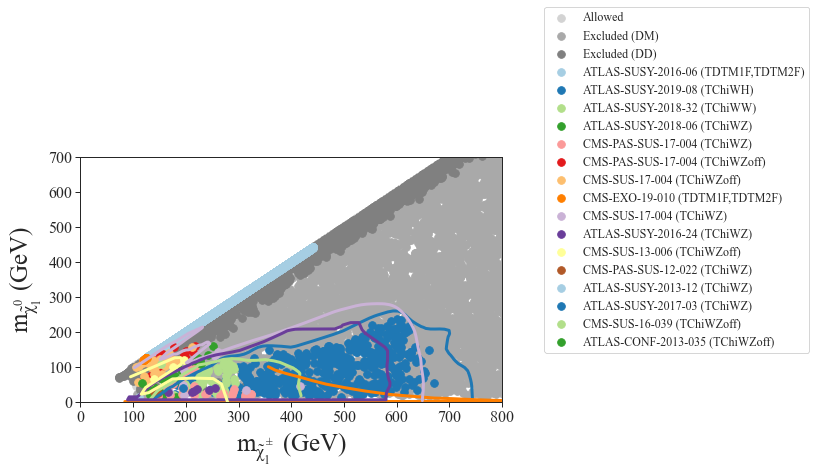

In [13]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(12,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

x = excludedDM['mass.1000024']
y = excludedDM['mass.1000022']
plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


x = excludedDD['mass.1000024']
y = excludedDD['mass.1000022']
plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)


for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['mass.1000022']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

for ana in anas.index:
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color=color)
        

lgd = plt.legend(loc=(1.1,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,700)
plt.xlim(0,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

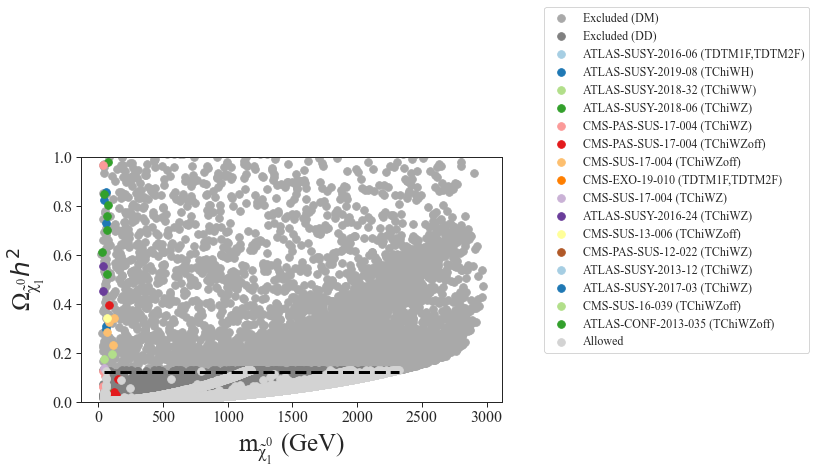

In [14]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(12,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'


x = excludedDM['mass.1000022']
y = excludedDM['Omega']
plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


x = excludedDD['mass.1000022']
y = excludedDD['Omega']
plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)


for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000022']
    y = excluded[excluded['label'] == ana]['Omega']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

    
x = allowed['mass.1000022']
y = allowed['Omega']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

        
plt.hlines(y=0.12,xmin=allowed['mass.1000022'].min(),xmax=allowed['mass.1000022'].max(),
           linewidth=3,linestyle='--',color='black')
lgd = plt.legend(loc=(1.1,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,1)
# plt.xlim(0,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{\Omega_{\tilde{\chi}_1^0}} h^2$',fontsize = 25)

plt.tight_layout()
plt.show()

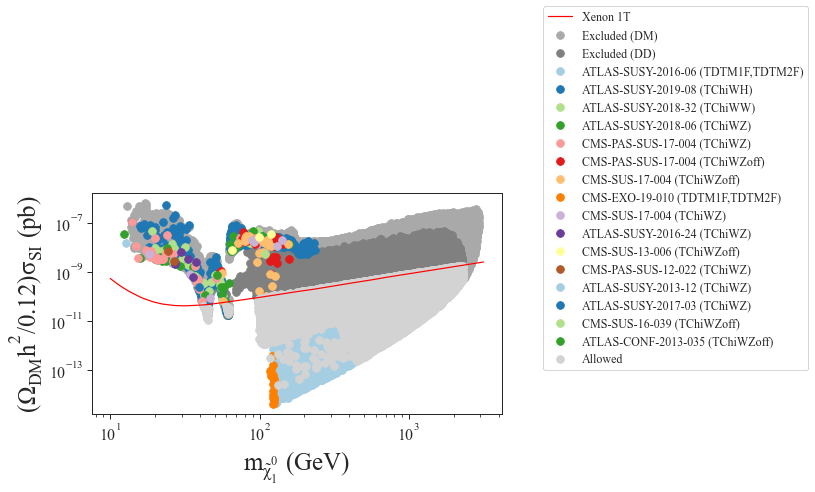

In [15]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
mDMlist = np.logspace(1,3.5,100)
sigUL = xenonUL(mDMlist)

plt.figure(figsize=(12,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'



x = excludedDM['mass.1000022']
y = (excludedDM['Omega']/0.12)*excludedDM['proton_SI']
plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


x = excludedDD['mass.1000022']
y = (excludedDD['Omega']/0.12)*excludedDD['proton_SI']
plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)


for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000022']
    y = (excluded[excluded['label'] == ana]['Omega']/0.12)*excluded[excluded['label'] == ana]['proton_SI']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

    
x = allowed['mass.1000022']
y = (allowed['Omega']/0.12)*allowed['proton_SI']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

        
plt.plot(mDMlist,sigUL,c='red',label='Xenon 1T')


lgd = plt.legend(loc=(1.1,0.2), framealpha=1.,fontsize=12)

# plt.ylim(0,1)
# plt.xlim(0,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{(\Omega_{DM} h^2/0.12) \sigma_{SI}}$ (pb)',fontsize = 25)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

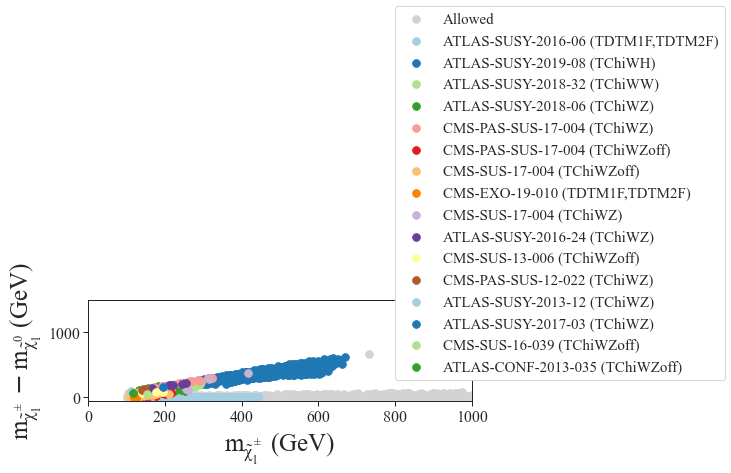

In [16]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(10,5))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
y = x-y
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['mass.1000022']
    y = x-y
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc=(0.8,0.2), framealpha=1.,fontsize=15)

plt.ylim(-50,1500)
plt.xlim(0,1000)

plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}-\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

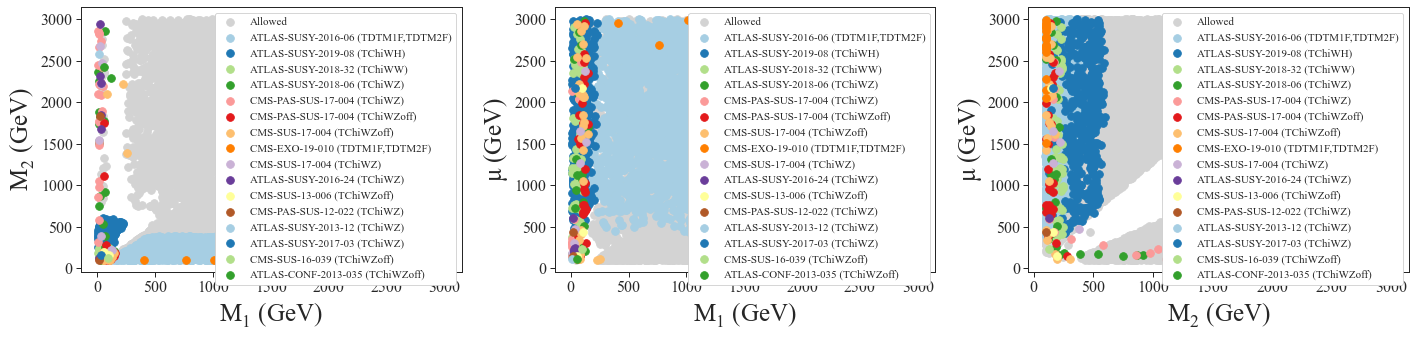

In [17]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)'}
i = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[i]
        x = allowed[xvar]
        y = allowed[yvar]
        ax.scatter(x,y,color=c_other,label='Allowed',s=60)
        for ana in anas.index:
            x = excluded[excluded['label'] == ana][xvar]
            y = excluded[excluded['label'] == ana][yvar]
            color = colorDict[ana]
            label = ana
            ax.scatter(x,y,color=color,label=label,s=60)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)
        i += 1     
        lgd = ax.legend(loc='upper right', framealpha=1.,fontsize=11)




plt.tight_layout()
plt.show()



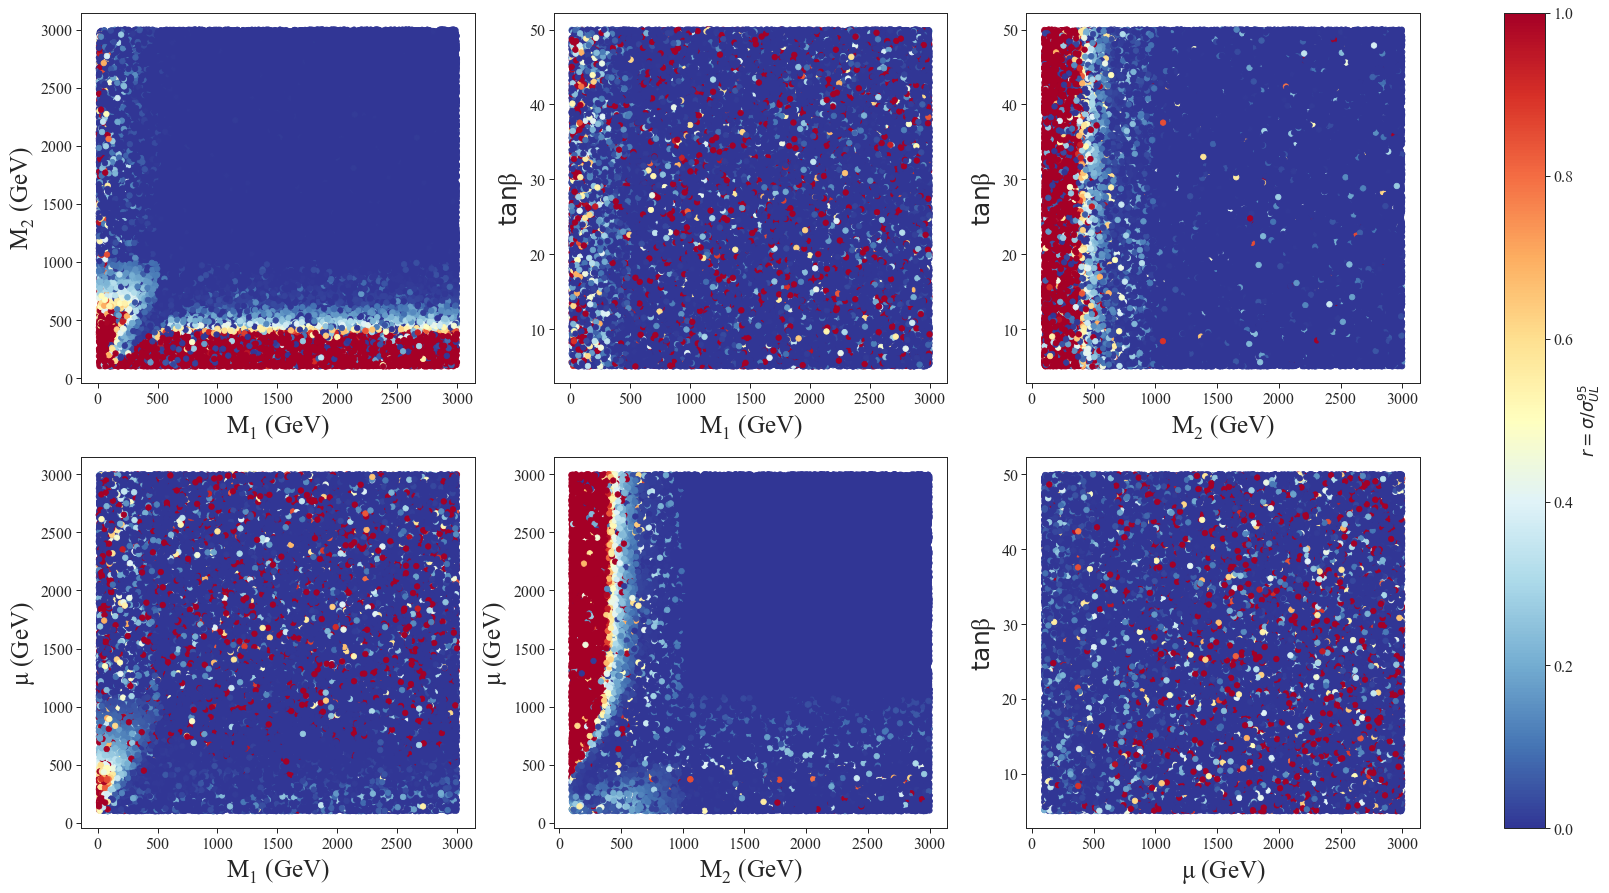

In [18]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15))
axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)',
             'extpar.25' : r'$\mathregular{\tan\beta}$'}

ii = 0
jj = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[ii,jj]
        x = dataDF[xvar]
        y = dataDF[yvar]
        z = dataDF['ExptRes.result0.r']
        x = x[z.argsort()]
        y = y[z.argsort()]
        z = z[z.argsort()]        
        a = ax.scatter(x,y,c=z,s=30,vmin=0,vmax=1,cmap=cm)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)    
        ii += 1
        if ii >= axes.shape[0]:
            ii = 0
            jj += 1

cb = fig.colorbar(a, ax=axes.ravel().tolist())
cb.set_label(r'$r = \sigma/\sigma_{UL}^{95}$')


plt.show()

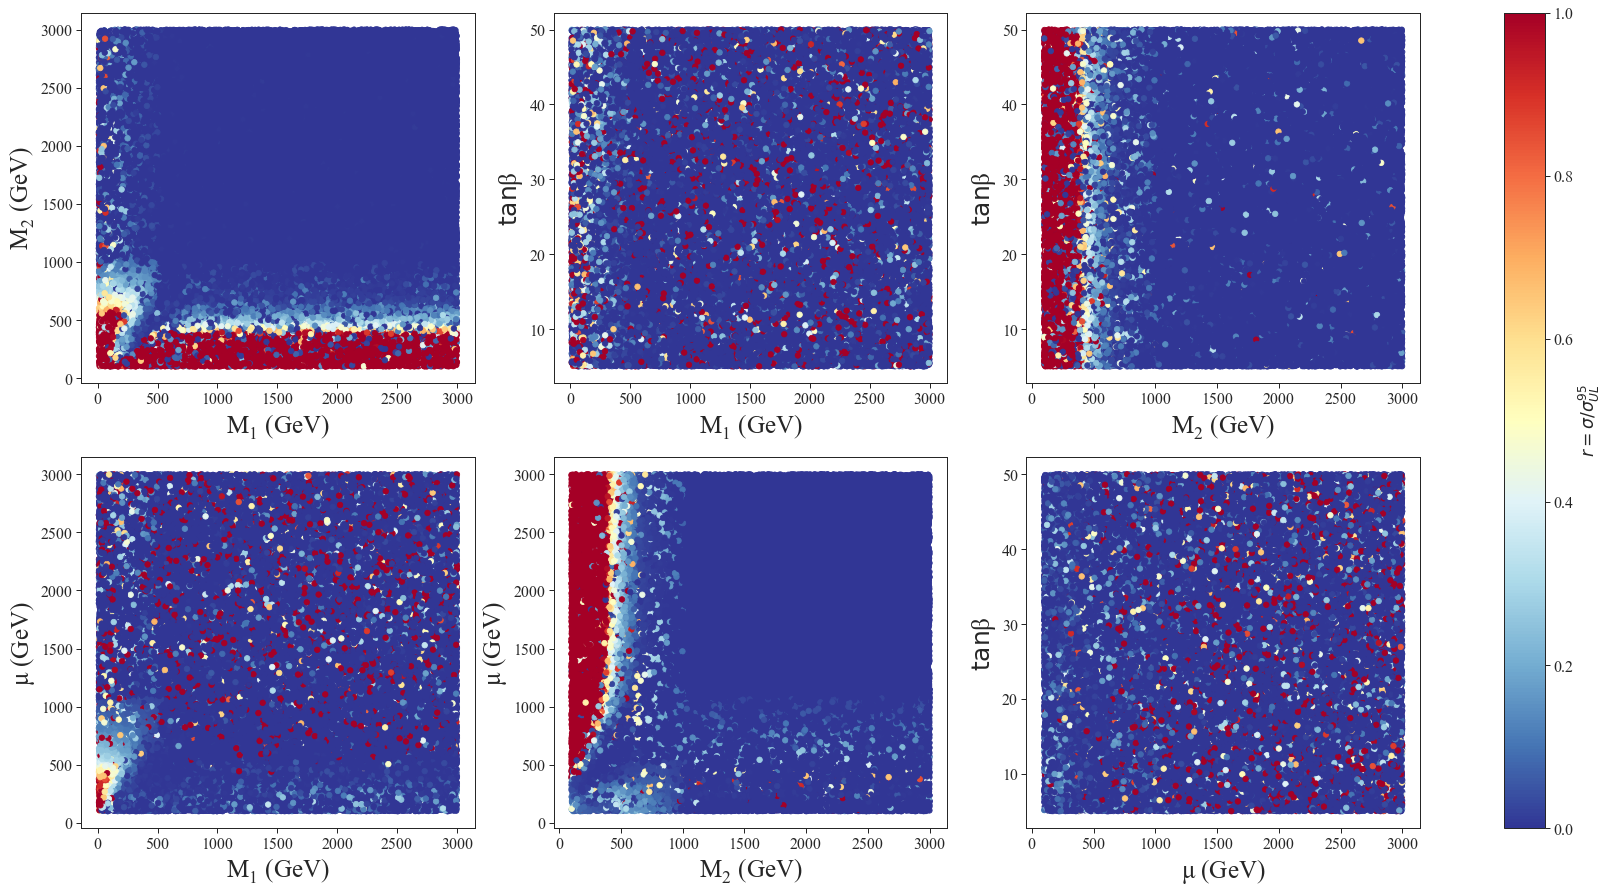

In [19]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15))
axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)',
             'extpar.25' : r'$\mathregular{\tan\beta}$'}

ii = 0
jj = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[ii,jj]
        x = dataDF[xvar]
        y = dataDF[yvar]
        z = dataDF['ExptRes.result0.r']
        x = x[(-z).argsort()]
        y = y[(-z).argsort()]
        z = z[(-z).argsort()]        
        a = ax.scatter(x,y,c=z,s=30,vmin=0,vmax=1,cmap=cm)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)    
        ii += 1
        if ii >= axes.shape[0]:
            ii = 0
            jj += 1

cb = fig.colorbar(a, ax=axes.ravel().tolist())
cb.set_label(r'$r = \sigma/\sigma_{UL}^{95}$')


plt.show()

In [20]:
# # Count points with 0.9 <= r < 1
# border = dataDF[(dataDF['ExptRes.result0.r'] > 0.7) & (dataDF['ExptRes.result0.r'] < 1.0)]
# print('%i files found' %len(border))
# #Copy files to ../EWino/data/slha_scanRandom_border
# for f in border['filename']:
#     f_old = os.path.join('../EWino/data/slha_scanRandom/',f)
#     f_new = os.path.join('../EWino/data/slha_scanRandom_border/',f)
#     shutil.copyfile(f_old,f_new)